# Association Mining!

The problem - How do you determine which items belong together from data? 
For example imagine you are running a store and you want to know what items are frequently bought together - how would you go about this in an automated and systematic way?

Apriori algorithm
* pro: Easy to implement, easy to parallelize
* con: Computationally expensive


Market basket analysis
 * Better shop layout
 * Adverse effects of combining medicine

Association rules are in the `if ... then ...` format. E.g:

> **If** a customer buys tomatoes and carrots **then** they buy tofu.

In formal logic this is called an implication, and is generally denoted with an arrow, so the statement above could be written:

> `{tomatoes, carrots} -> tofu`

Association mining in this case might lead us to the conclusion that 'tofu' should be considered as a vegetable, rather than as an oriental item, as it it is frequently bought by vegetarians.

___

Important metrics in apriori are:
* Support - of an item set X is the proportion of observations in the dataset where X occurs
    * $supp(X) = \frac{\text{# observations with X}}{\text{Total # transactions}}$
* Confidence - How strong is the rule? I.e. the confidence for `X->Y` is the likelihood that `Y` is purchased, if `X` is purchased. 
This is the same as the conditional probability.
It is defined as follows:
    * $conf(X \rightarrow Y) = \frac{supp(X \cup Y)}{supp(X)}$
* Lift
    * If the support for `Y` is very high, then the confidence of `X->Y` might not be very informative. 
    Lift corrects for this.
    * $lift(X\rightarrow Y) = \frac{supp(X \cup Y)}{supp(X) supp(Y)}$


Example work
1. Load data
1. Create itemsets of one-hot DataFrame
1. Determine minimum support (and confidence) threshold
    1. Some data exploration 
1. Find all items that satisfies this support threshold
1. Find all combinations of the items that satisfy the support threshold. You can use arbitrarily large sets.



In [1]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json # <- this package is super useful to read/write json data :D
from pprint import pprint
from itertools import combinations


# The Data

For this exercise we will be working with classical shopping-cart data.
The cell below loads the data and prints the first example.
- After loading a json file, you can access its elements with "\[\]" just like you would do with a python array or dictionary:
  - data_json[0] -> Get the first entry
  - data_json[0]["items"] -> Get the list of items of the first entry 

In [2]:
# Check that data and data path is present
data_folder = "../data/"
data_filename = "shopping.json"
assert os.path.isdir(data_folder) and os.path.exists(data_folder + data_filename), 'Data not found. Make sure to have the most recent version!'

# Load json data
with open(data_folder + data_filename) as f:
    data_json = json.load(f)

# Examine data
print('Number of observations', len(data_json))
pprint(data_json[0])

Number of observations 1499
{'date': '1/1/2000',
 'items': ['yogurt',
           'pork',
           'sandwich bags',
           'lunch meat',
           'all- purpose',
           'flour',
           'soda',
           'butter',
           'vegetables',
           'beef',
           'aluminum foil',
           'all- purpose',
           'dinner rolls',
           'shampoo',
           'all- purpose',
           'mixes',
           'soap',
           'laundry detergent',
           'ice cream',
           'dinner rolls',
           '']}


## Task 1: Transforming the Data

The first thing we want to do is transform the data into a one-hot (numpy) matrix.
A one-hot matrix is a matrix where each column represent an item, e.g. `ice cream`, and each row represents a transaction.
`0` indicates the item wasn't bought, and `1` indicates that it was.

Your task is to
1. Create a list of all the feature names, but remove the uninformative ones, i.e. the ones in `bad_feature_names`
1. Create a one-hot numpy array of the data, and name it `data`
 * Note: If an item occurs twice in a transaction we still just want to have a `1` in the one-hot matrix.
 * Hint: The array should have shape `(1499, 37)`
 

In [3]:
num_observations = len(data_json)
bad_feature_names = ['', 'all- purpose'] 

# Make a set with all of the possible items
all_items = set()
## YOUR CODE HERE
for i in range(num_observations):
    for item in data_json[i]['items']:
        all_items.add(item)

# Remove bad item names from all_items
## YOUR CODE HERE
for bad_feature in bad_feature_names:
    all_items.remove(bad_feature) 
        
# Convert all_items to a list to get the feature names (from now on the order is important)
# features_names = ## YOUR CODE HERE
features_names = list(all_items)

print('feature_names')
print(features_names)
print()

# Create a one-hot matrix (data)
num_features = len(features_names)
data = np.zeros([num_observations, num_features])
## YOUR CODE HERE
for i in range(num_observations):
    for item in data_json[i]['items']:
        if item in all_items: # check if it's a valid item
            j = features_names.index(item) # find its index
            data[i,j] = 1

print('The data looks like this now:')
data

feature_names
['individual meals', 'waffles', 'cheeses', 'ketchup', 'pork', 'ice cream', 'milk', 'toilet paper', 'soda', 'laundry detergent', 'spaghetti sauce', 'cereals', 'sandwich bags', 'coffee/tea', 'sugar', 'pasta', 'eggs', 'bagels', 'juice', 'aluminum foil', 'hand soap', 'dishwashing liquid/detergent', 'dinner rolls', 'sandwich loaves', 'flour', 'beef', 'mixes', 'butter', 'tortillas', 'fruits', 'vegetables', 'soap', 'paper towels', 'lunch meat', 'yogurt', 'shampoo', 'poultry']

The data looks like this now:


array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Compute the Support

Now we want to compute the support of each of the individual items, and visualize it.

1. The `compute_support` function computes the support for an itemset. 
 * E.g. `[0,1,2]` would be `{'aluminum foil', 'bagels', 'beef',}`, which occurs 7.20% of the time.
1. Compute the support of each of the items individually - i.e. how frequent are each item.
1. Visualize the support as a histogram.
    * `plt.xticks` can be used to rotate the labels on the x-axis for a prettier plot.

Support for [0,1,2]: 0.07071380920613743


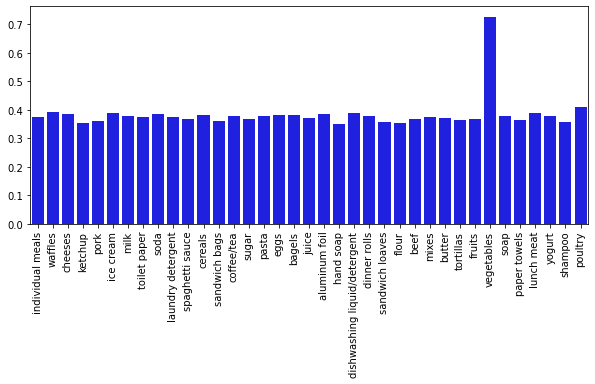

In [4]:
def compute_support(matrix, itemset):
    """ Given a one-hot array matrix, and an itemset (a list), indicating the columns of interest
        compute_support returns the support of the elements in itemset.
        
        The support of an item set X is the proportion of observations in the dataset where X occurs.
        $supp(X) = \frac{\text{# observations with X}}{\text{Total # transactions}}$
    """
    rule = matrix[:, itemset].all(axis=1)
    support = rule.sum() / matrix.shape[0]
    return support

print('Support for [0,1,2]:', compute_support(data, [0,1,2]))

# Calculate the support for each 1-Itemset (1-Itemset = itemset composed by one single item)
support = []
for i in range(data.shape[1]):
    support.append(compute_support(data, (i,)))

plt.figure(figsize=(10,4))
g = sns.barplot(x=features_names, y=support, color='b')
plt.xticks(rotation=90)
plt.show()

## Task 2: Creating M+1-Itemsets

Here we want to implement and test a helper function `generate_M_plus_1_itemsets`.
The function takes a `NxM` **list** of item sets.
`N` indicates the number of item sets, and `M` indicates the length.
The function should then produce a new **list** with all the new itemsets of length `M+1`.

Your task:
1. Fill out the function `generate_M_plus_1_itemsets`. The output must be a **list** of itemsets. Each itemset is a **list**.
 * Note: Watch out you **don't create duplicates!** We don't care about the order, so `[0, 1]` is the same as `[1, 0]`.
 * It is a good idea to start by finding all the unique values in old_combinations.
1. Run the test in the next cell, and make sure that you get the correct result.

In [5]:
def generate_M_plus_1_itemsets(old_combinations):
    """ Input: The NxM list of M-itemsets, 
            N: number of combinations
            M: length of each item set
        Output: The ?xM+1 list of M+1-itemsets
    """
    
    items_types_in_previous_step = np.unique(old_combinations)
    new_combinations = []
    ## YOUR CODE HERE 
    for old_combination in old_combinations:
        max_item = np.max(old_combination)
        for item in items_types_in_previous_step:
            if item > max_item:
                new_itemset = old_combination + [item]
                new_combinations.append(new_itemset)
    
    return new_combinations

The cell below serves as a test of `generate_M_plus_1_itemsets`. 
If your function is written correctly the output shold be as follows:

    Itemset length: 1
    [[0], [1], [2], [3]]

    Itemset length: 2
    [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

    Itemset length: 3
    [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

    Itemset length: 4
    [[0, 1, 2, 3]]

In [6]:
# Test of candidate_generation
comb = [[i] for i in range(0, 4)]
while len(comb)>0:
    print('Itemset length:', len(comb[0]))
    print(comb)
    print()
    comb = generate_M_plus_1_itemsets(comb)


Itemset length: 1
[[0], [1], [2], [3]]

Itemset length: 2
[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

Itemset length: 3
[[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

Itemset length: 4
[[0, 1, 2, 3]]



## Task 3: Apriori Step 1: Find Frequent Itemsets

In this task we will find all the sets that have sufficient support.

Your task:
1. Finish the code below using what you have already done in the previous tasks. Each iteration of the loop should:
 * Generate all relevant combinations.
 * For each combination compute the support
 * If the support is larger than `min_support` save the item set and the support in `itemset_dict` and `support_dict`.
1. Convert your results, `itemset_dict` and `support_dict`, into a `pandas` dataframe.
 * Use `reset_index` to fix the indexes (remove the unwanted 'history')
 * Convert the item sets to `frozenset`. `frozenset` is a [immutable data structure for sets](https://www.programiz.com/python-programming/methods/built-in/frozenset) that enables common set operations like union, intersection, difference (some of which may come in handy later *wink wink*)
1. Find an appropriate minimum support (subjective). Run the code several times, and see how changing this value changes the outcome.
 * You may choose a maximum length as well if you want to.
1. Print the results using the actual feature names - how does it look? Any surprises?

In [7]:
min_support = 0.3

# Find the frequent 1-itemsets by calculating their support
# Store the supports and the frequent 1-itemsets in 2 dictionaries
# (frequent_1_itemsets_support and frequent_1_itemsets) at key=1
frequent_1_itemsets_support = []
frequent_1_itemsets = []
for i in range(data.shape[1]):
    support = compute_support(data, [i])
    if support >= min_support:
        frequent_1_itemsets_support.append(support)
        frequent_1_itemsets.append([i])
support_dict = {1: frequent_1_itemsets_support}
itemset_dict = {1: frequent_1_itemsets}

rows_count = float(data.shape[0])
itemset_len = 1
while itemset_len > 0:

    next_itemset_len = itemset_len + 1
    
    frequent_itemsets = []
    frequent_itemsets_support = []

    # Generate the k+1 itemsets
    ## YOUR CODE HERE
    new_itemsets = generate_M_plus_1_itemsets(itemset_dict[itemset_len])
    # Store the frequent itemsets and their support in frequent_itemsets and frequent_itemsets_support respectively
    for new_itemset in new_itemsets:
        ## YOUR CODE HERE
        support = compute_support(data, new_itemset)
        if support >= min_support:
            frequent_itemsets.append(new_itemset)
            frequent_itemsets_support.append(support)

    if len(frequent_itemsets):
        # Add the frequent itemsets and their support to the dictionaries at key=next_itemset_len
        ## YOUR CODE HERE
        itemset_dict[next_itemset_len] = frequent_itemsets
        support_dict[next_itemset_len] = np.array(frequent_itemsets_support)
        itemset_len = next_itemset_len
    else:
        itemset_len = 0

# 2 Convert the 2 dictionaries into a Pandas dataframe
all_res = []
for k in sorted(itemset_dict):
    support = pd.Series(support_dict[k])
    itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]]) # <- notice the frozenset (see info above)

    res = pd.concat((support, itemsets), axis=1)
    all_res.append(res)

res_df = pd.concat(all_res)
res_df.columns = ['support', 'itemsets']
res_df = res_df.reset_index(drop=True)


# Print results in a human readable manner
for i in range(37, len(res_df)):
    print([features_names[i] for i in res_df.itemsets[i]], '\t has support {:.4f}'.format(res_df.support[i]))


['waffles', 'vegetables'] 	 has support 0.3049
['cheeses', 'vegetables'] 	 has support 0.3035
['ice cream', 'vegetables'] 	 has support 0.3009
['laundry detergent', 'vegetables'] 	 has support 0.3042
['eggs', 'vegetables'] 	 has support 0.3109
['aluminum foil', 'vegetables'] 	 has support 0.3095
['dishwashing liquid/detergent', 'vegetables'] 	 has support 0.3049
['lunch meat', 'vegetables'] 	 has support 0.3015
['yogurt', 'vegetables'] 	 has support 0.3082
['poultry', 'vegetables'] 	 has support 0.3202


In [8]:
res_df

,support,itemsets
0,0.374249,(0)
1,0.391594,(1)
2,0.386925,(2)
3,0.355570,(3)
4,0.359573,(4)
5,0.389593,(5)
6,0.378252,(6)
7,0.375584,(7)
8,0.386258,(8)
9,0.375584,(9)


## Task 4: Confidence, Lift

Complete the functions computing confidence, and lift

In [9]:
def compute_confidence(supportAntecedentConsequent, supportAntecedent):
    """ The confidence for `X->Y` is the likelihood that `Y` is purchased, if `X` is purchased. 
        This is the same as the conditional probability.
        $conf(X \rightarrow Y) = \frac{supp(X \cup Y)}{supp(X)}$
    """
    ## YOUR CODE HERE
    return supportAntecedentConsequent / supportAntecedent

def compute_lift(supportAntecedentConsequent, supportAntecedent, supportConsequent):
    """ 
        $lift(X\rightarrow Y) = \frac{supp(X \cup Y)}{supp(X) supp(Y)}$        
    """
    ## YOUR CODE HERE
    conf = compute_confidence(supportAntecedentConsequent, supportAntecedent)
    return conf / supportConsequent


## Apriori Step 2: Find the Association Rules

Now we put it all together, and complete the apriori algorithm!

1. Write a for-loop that for each set of size 2 or larger
 * computes all possilbe association rules (e.g. {A, B, C} becomes {{A -> B, C}, {A, B -> C}, {A, C -> B}, {B, C -> A})
 * for each association rule compute the score (`score_function`). 
 * If the score is larger than the threshold save the support for the entire set, the antecedent, and the concequent.
1. Create a pandas dataframe with all the metrics, and have a look at it.
1. Experiment with different selection metrics and thresholds. What gives results that look reasonable?

You can generate all the combinations of size *size* with [Itertools.combinations(A, size)](https://www.geeksforgeeks.org/python-itertools-combinations-function/#:~:text=Similarly%20itertools.,are%20emitted%20in%20lexicographical%20order.). For example, if `A=['a','b','c']`, then `list(combinations(A, 2))` is `[['a', 'b'], ['a', 'c'], ['b', 'c']]`

In [10]:
score_function = lambda supAC, supA, supC: compute_confidence(supAC, supA)
min_threshold = 0.3

itemsets = res_df['itemsets'].values
itemsets_support = res_df['support'].values

frequent_items_dict = {}
for i in range(len(itemsets)):
    frequent_items_dict[frozenset(itemsets[i])] = itemsets_support[i]

# prepare buckets to collect frequent rules
rule_antecedents = []
rule_consequents = []
rule_supports = []

# iterate over all frequent itemsets
for itemset in frequent_items_dict.keys():
    supportAntCons = frequent_items_dict[itemset]

    # find all possible combinations of itemsets
    for idx in range(len(itemset)-1, 0, -1):
        # of antecedent and consequent
        for subset in combinations(itemset, r=idx): # loop over the combinations of size idx (see combinations from package itertools)
            antecedent = frozenset(subset)
            consequent = itemset.difference(antecedent)

            supportAnt = frequent_items_dict[antecedent]
            supportCons = frequent_items_dict[consequent]
            score = score_function(supportAntCons, supportAnt, supportCons)
            if score >= min_threshold:
                rule_antecedents.append(antecedent)
                rule_consequents.append(consequent)
                rule_supports.append([supportAntCons, supportAnt, supportCons])

# generate metrics
rule_supports = np.array(rule_supports).T.astype(float)

# convert ids to item string name
rule_antecedents_string = [frozenset(features_names[j] for j in i) for i in rule_antecedents]
rule_consequents_string = [frozenset(features_names[j] for j in i) for i in rule_consequents]

df_res = pd.DataFrame(
    data=list(zip(rule_antecedents_string, rule_consequents_string)),
    columns=["antecedents", "consequents"])

supportAntCons = rule_supports[0]
supportAnt = rule_supports[1]
supportCons = rule_supports[2]

df_res['total_support'] = supportAntCons
df_res['antecedent_support'] = supportAnt
df_res['consequent_support'] = supportCons
df_res['confidence'] = compute_confidence(supportAntCons, supportAnt)
df_res['lift'] = compute_lift(supportAntCons, supportAnt, supportCons)

df_res

,antecedents,consequents,total_support,antecedent_support,consequent_support,confidence,lift
0,(waffles),(vegetables),0.304870,0.391594,0.726484,0.778535,1.071647
1,(vegetables),(waffles),0.304870,0.726484,0.391594,0.419651,1.071647
2,(cheeses),(vegetables),0.303536,0.386925,0.726484,0.784483,1.079834
3,(vegetables),(cheeses),0.303536,0.726484,0.386925,0.417815,1.079834
4,(ice cream),(vegetables),0.300867,0.389593,0.726484,0.772260,1.063010
5,(vegetables),(ice cream),0.300867,0.726484,0.389593,0.414141,1.063010
6,(laundry detergent),(vegetables),0.304203,0.375584,0.726484,0.809947,1.114885
7,(vegetables),(laundry detergent),0.304203,0.726484,0.375584,0.418733,1.114885
8,(eggs),(vegetables),0.310874,0.381588,0.726484,0.814685,1.121408
9,(vegetables),(eggs),0.310874,0.726484,0.381588,0.427916,1.121408
